# Baseline Model for Twitter Sentiment Analysis

This model will use Multinomial Naive Bayes with tf/idf to classify the tweets.

It will reduce the dimensionality of the feature set by adjusting the minimum document frequency of words, in an attempt to get better results.

# Imports and Constants

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
import evaluation_functions
from sklearn.feature_extraction.text import TfidfTransformer
import ast

In [2]:
DATA_FILE_PATH = '../data/crowdflower-brands-and-product-emotions/data/'
TOKENIZED_DATA_FILE_NAME = 'tokenized_twitter_data.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [3]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [4]:
df.head()

tweet_text  \
0             i have a g iphone after  hrs tweeting at #riseaustin it was dead  i need to upgrade plugin stations at #sxsw   
1   know about   awesome ipad/iphone app that you'll likely appreciate for its design also they're giving free ts at #sxsw   
2                                                         can not wait for #ipad  also they should sale them down at #sxsw   
3                                              i hope this year's festival isn't as crashy as this year's iphone app #sxsw   
4       great stuff on fri #sxsw: marissa mayer (google) tim o'reilly (tech books/conferences)  matt mullenweg (wordpress)   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  \
0                                   Negative emotion   
1                                   Positive emotion   
2                                   Positive emotion   
3                                   Negative emotion   
4                                   Positive emotion   

                                                                                                                                                                              tokens  
0         ['i', 'have', 'a', 'g', 'iphone', 'after', 'hrs', 'tweeting', 'at', '#riseaustin', 'it', 'was', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'stations', 'at', '#sxsw']  
1  ['know', 'about', 'awesome', 'ipad', 'iphone', 'app', 'that', "you'll", 'likely', 'appreciate', 'for', 'its', 'design', 'also', "they're", 'giving', 'free', 'ts', 'at', '#sxsw']  
2                                                                            ['can', 'not', 'wait', 'for', '#ipad', 'also', 'they', 'should', 'sale', 'them', 'down', 'at', '#sxsw']  
3                                                             ['i', 'hope', 'this', "year's", 'festival', "isn't", 'as', 'crashy', 'as', 'this', "year's", 'iphone', 'app', '#sxsw']  
4                        ['great', 'stuff', 'on', 'fri', '#sxsw', 'marissa', 'mayer', 'google', 'tim', "o'reilly", 'tech', 'books', 'conferences', 'matt', 'mullenweg', 'wordpress']

In [5]:
# convert list of strings represented as a string to a list of strings
df.tokens = df.tokens.map(ast.literal_eval)

In [6]:
data = df[['tokens', 'is_there_an_emotion_directed_at_a_brand_or_product']]

In [7]:
data.head()

tokens  \
0           [i, have, a, g, iphone, after, hrs, tweeting, at, #riseaustin, it, was, dead, i, need, to, upgrade, plugin, stations, at, #sxsw]   
1  [know, about, awesome, ipad, iphone, app, that, you'll, likely, appreciate, for, its, design, also, they're, giving, free, ts, at, #sxsw]   
2                                                              [can, not, wait, for, #ipad, also, they, should, sale, them, down, at, #sxsw]   
3                                                 [i, hope, this, year's, festival, isn't, as, crashy, as, this, year's, iphone, app, #sxsw]   
4                [great, stuff, on, fri, #sxsw, marissa, mayer, google, tim, o'reilly, tech, books, conferences, matt, mullenweg, wordpress]   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

# Split Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], 
                                                    data['is_there_an_emotion_directed_at_a_brand_or_product'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = data['is_there_an_emotion_directed_at_a_brand_or_product'])

In [9]:
X_train.shape

(6855,)

In [10]:
X_test.shape

(1714,)

# Encode Labels

In [11]:
le = LabelEncoder()

In [12]:
y_train_enc = le.fit_transform(y_train)

In [13]:
y_test_enc = le.transform(y_test)

# Evaluate Adjustments to Minimum Document Frequency

In [14]:
def passthrough(doc):
    """passthrough function for use in the pipeline because the text is already tokenized"""
    return doc

In [15]:
def train_and_eval_model(min_df):
    """
    Train and Evaluate and Bag of Words Representation with a Naive Bayes
    classifier with a specified minimum document frequency.
    """
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df=min_df,
                           preprocessor=passthrough, 
                           tokenizer=passthrough)),  
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    
    evaluation_functions.confustion_matrix_and_classification_report(pipeline, 
                                                                 X_train, 
                                                                 y_train_enc, 
                                                                 le.classes_, 
                                                                 'Training')
    
    evaluation_functions.confustion_matrix_and_classification_report(pipeline, 
                                                                 X_test, 
                                                                 y_test_enc, 
                                                                 le.classes_,
                                                                 'Test')
    
    lb = LabelBinarizer()
    lb.fit(y_test_enc)
    y_test_multi = lb.transform(y_test_enc)
    y_hat_test_multi = pipeline.predict_proba(X_test)
    
    evaluation_functions.pr_curves(y_test_multi, y_hat_test_multi, le.classes_)
    
    train_accuracy = accuracy_score(y_train_enc, pipeline.predict(X_train))
    
    test_accuracy = accuracy_score(y_test_enc, pipeline.predict(X_test))
        
    recall_scores = recall_score(y_test_enc, pipeline.predict(X_test), average=None)
    
    test_results = np.append(np.array([min_df, train_accuracy, test_accuracy]),
                             recall_scores)
   
    return test_results
    

MINIMUM DOCUMENT FREQUENCY = 1

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       1.00      0.03      0.05       436
No emotion toward brand or product       0.70      0.99      0.82      4124
                  Positive emotion       0.91      0.41      0.57      2295

                          accuracy                           0.73      6855
                         macro avg       0.87      0.48      0.48      6855
                      weighted avg       0.79      0.73      0.69      6855



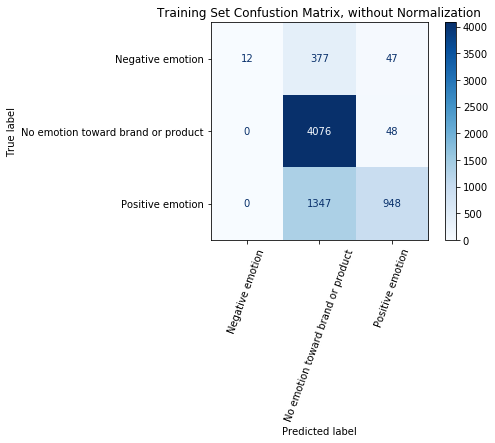

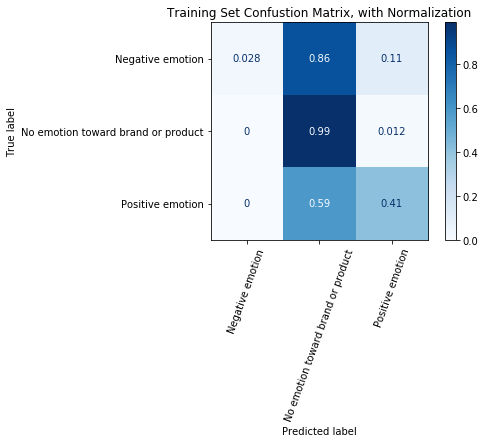

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.67      0.02      0.04       109
No emotion toward brand or product       0.65      0.96      0.77      1031
                  Positive emotion       0.72      0.22      0.34       574

                          accuracy                           0.65      1714
                         macro avg       0.68      0.40      0.38      1714
                      weighted avg       0.67      0.65      0.58      1714



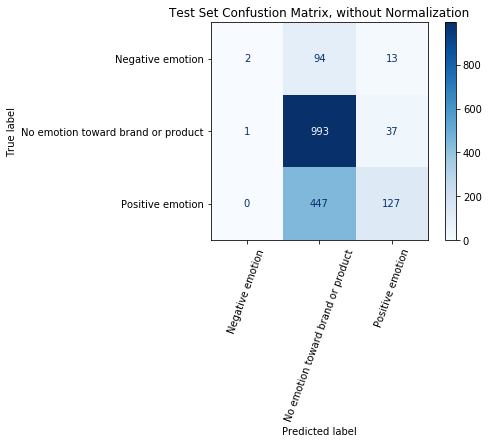

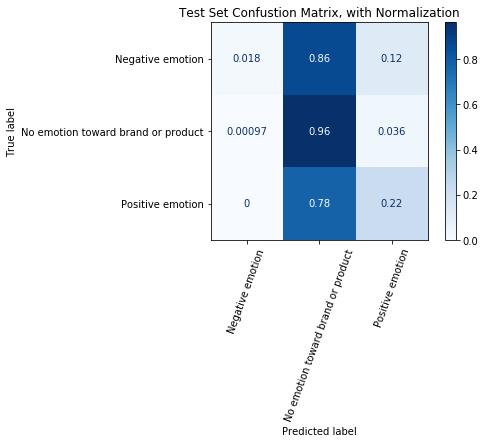

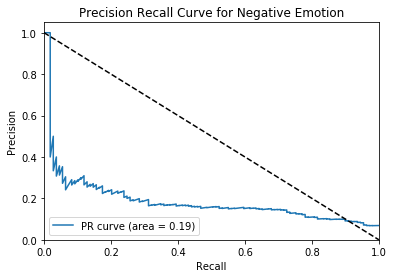

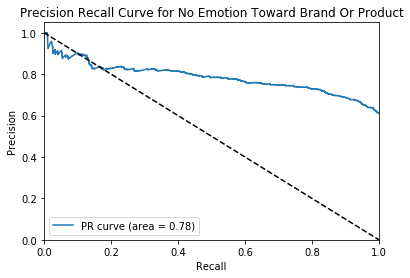

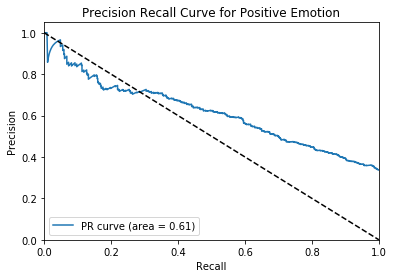

MINIMUM DOCUMENT FREQUENCY = 2

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       1.00      0.06      0.10       436
No emotion toward brand or product       0.72      0.97      0.83      4124
                  Positive emotion       0.85      0.47      0.61      2295

                          accuracy                           0.75      6855
                         macro avg       0.86      0.50      0.51      6855
                      weighted avg       0.78      0.75      0.71      6855



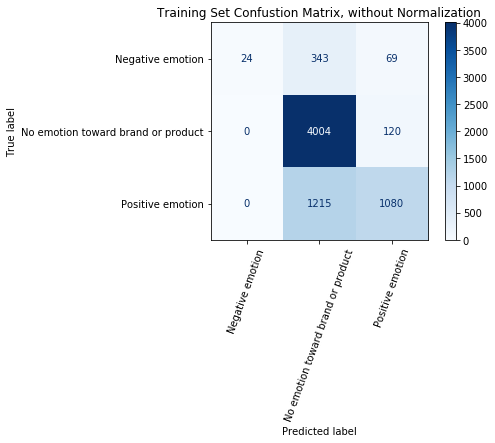

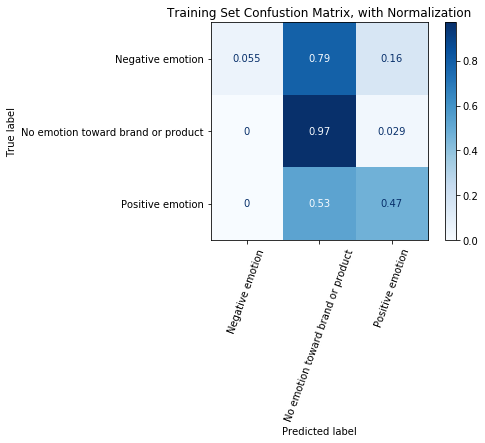

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.67      0.02      0.04       109
No emotion toward brand or product       0.67      0.94      0.78      1031
                  Positive emotion       0.70      0.30      0.42       574

                          accuracy                           0.67      1714
                         macro avg       0.68      0.42      0.41      1714
                      weighted avg       0.68      0.67      0.61      1714



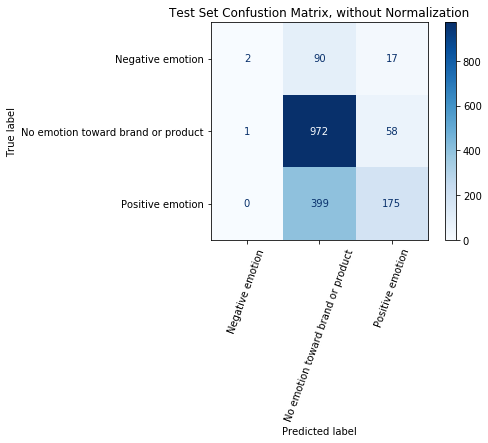

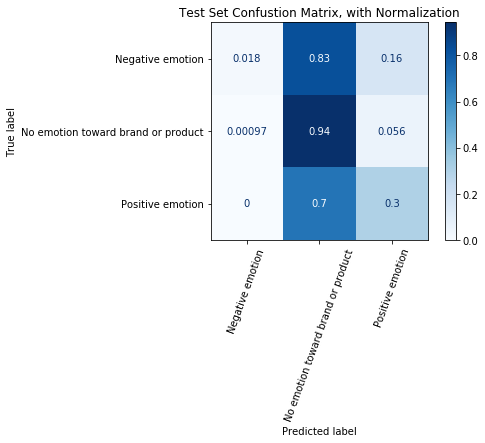

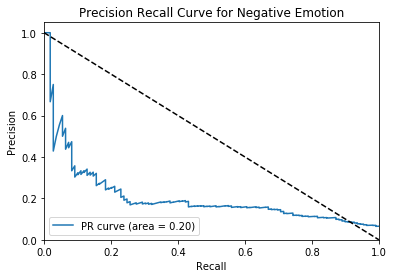

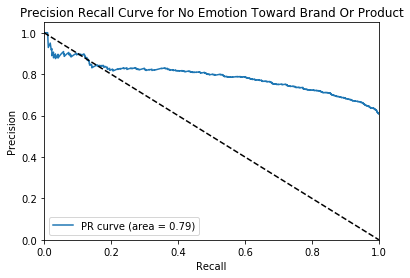

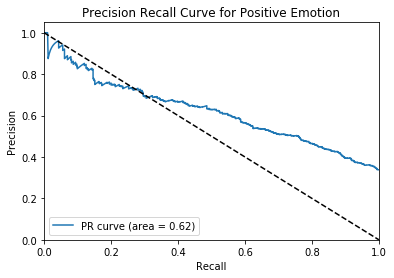

MINIMUM DOCUMENT FREQUENCY = 3

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.97      0.07      0.13       436
No emotion toward brand or product       0.72      0.96      0.82      4124
                  Positive emotion       0.81      0.48      0.60      2295

                          accuracy                           0.74      6855
                         macro avg       0.83      0.50      0.52      6855
                      weighted avg       0.77      0.74      0.71      6855



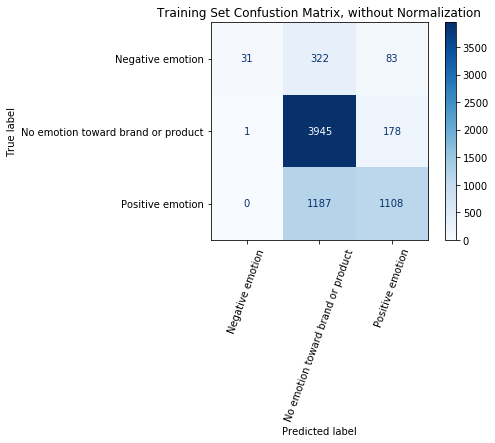

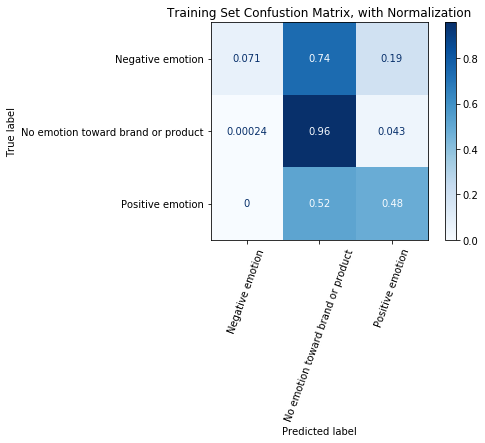

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.67      0.02      0.04       109
No emotion toward brand or product       0.67      0.91      0.78      1031
                  Positive emotion       0.66      0.36      0.47       574

                          accuracy                           0.67      1714
                         macro avg       0.67      0.43      0.43      1714
                      weighted avg       0.67      0.67      0.62      1714



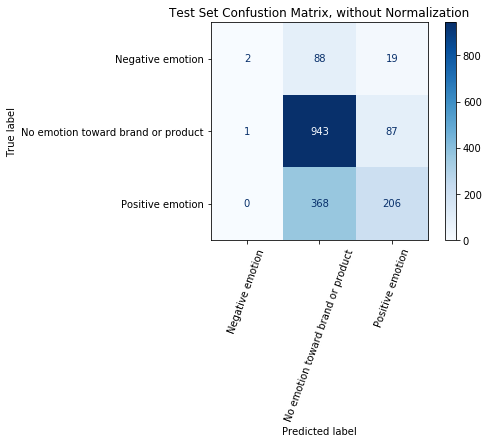

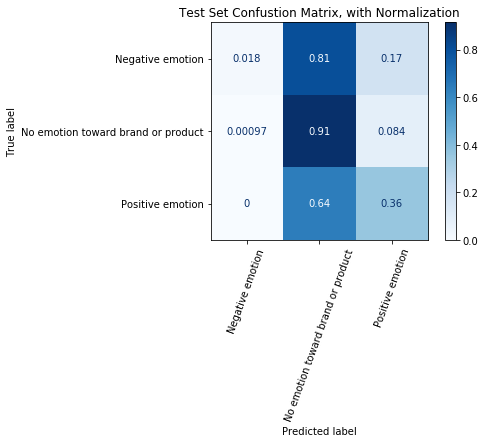

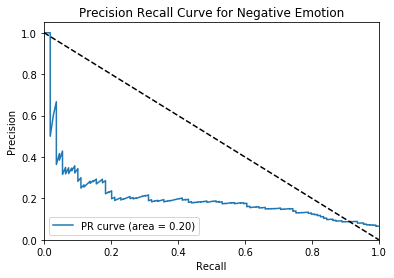

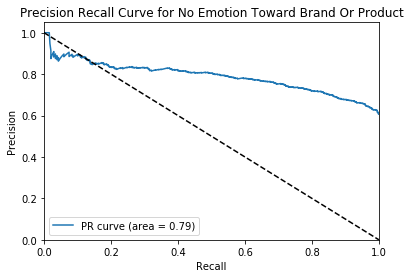

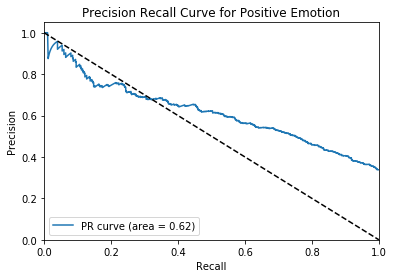

MINIMUM DOCUMENT FREQUENCY = 4

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.97      0.06      0.12       436
No emotion toward brand or product       0.72      0.95      0.82      4124
                  Positive emotion       0.78      0.48      0.59      2295

                          accuracy                           0.73      6855
                         macro avg       0.82      0.50      0.51      6855
                      weighted avg       0.76      0.73      0.70      6855



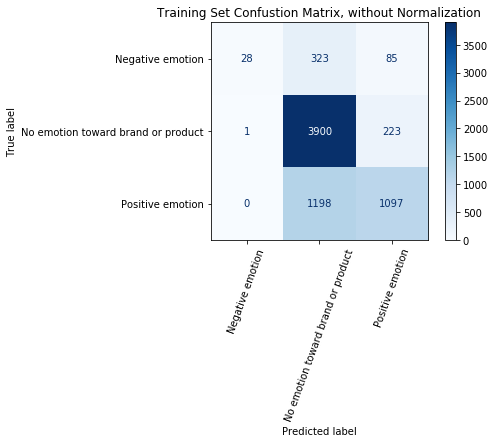

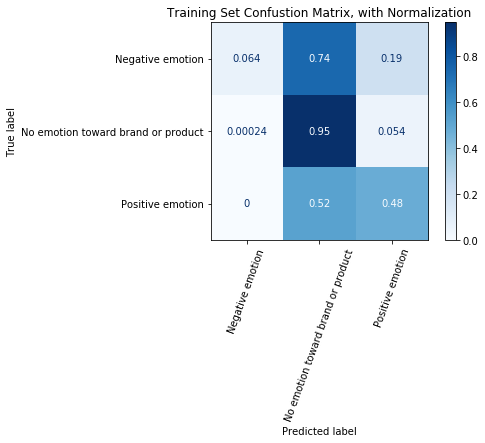

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.50      0.02      0.04       109
No emotion toward brand or product       0.68      0.90      0.77      1031
                  Positive emotion       0.64      0.38      0.48       574

                          accuracy                           0.67      1714
                         macro avg       0.61      0.43      0.43      1714
                      weighted avg       0.65      0.67      0.63      1714



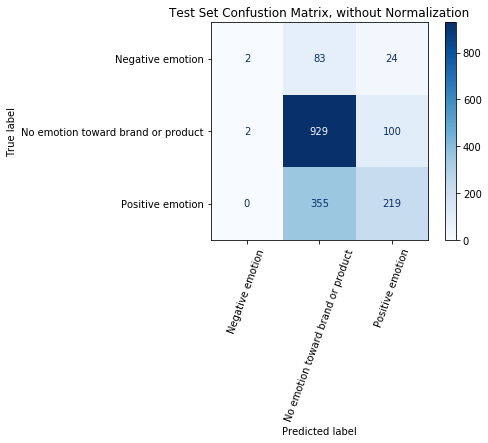

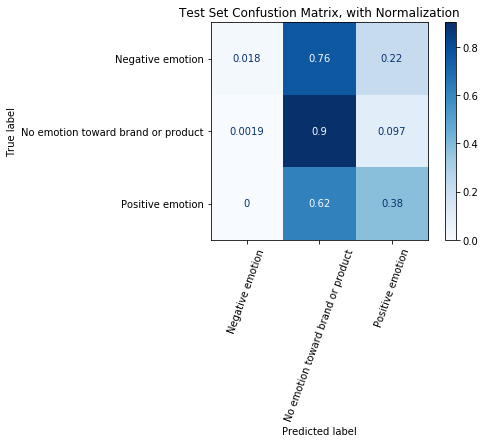

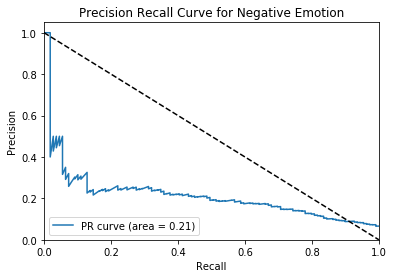

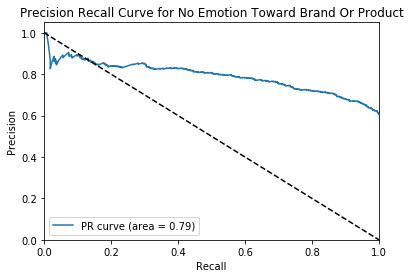

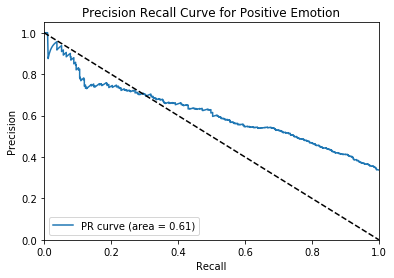

MINIMUM DOCUMENT FREQUENCY = 5

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.97      0.06      0.12       436
No emotion toward brand or product       0.72      0.94      0.81      4124
                  Positive emotion       0.77      0.47      0.58      2295

                          accuracy                           0.73      6855
                         macro avg       0.82      0.49      0.51      6855
                      weighted avg       0.75      0.73      0.69      6855



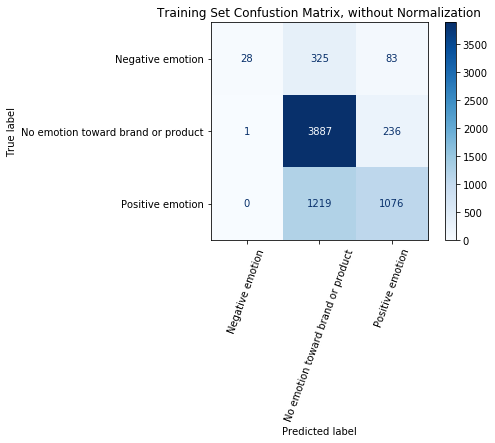

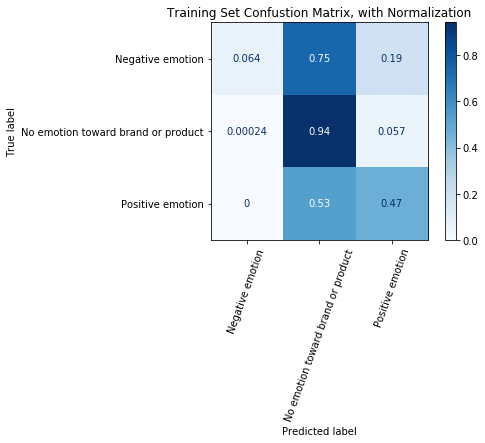

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.50      0.02      0.04       109
No emotion toward brand or product       0.68      0.90      0.77      1031
                  Positive emotion       0.63      0.38      0.47       574

                          accuracy                           0.67      1714
                         macro avg       0.60      0.43      0.43      1714
                      weighted avg       0.65      0.67      0.63      1714



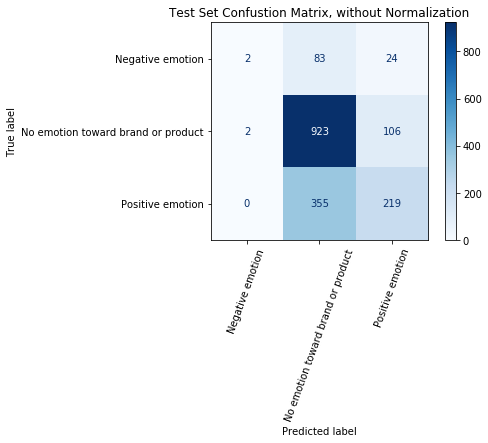

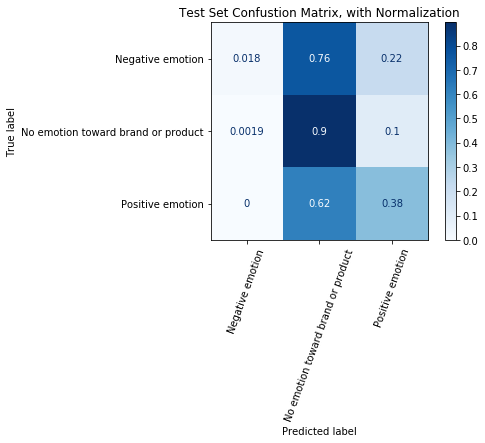

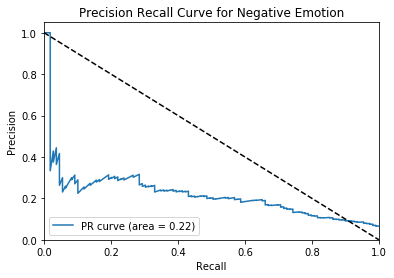

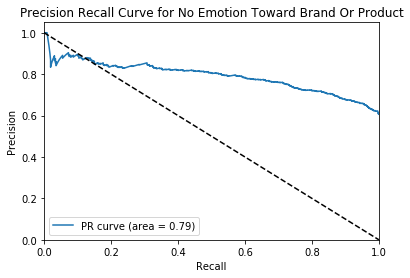

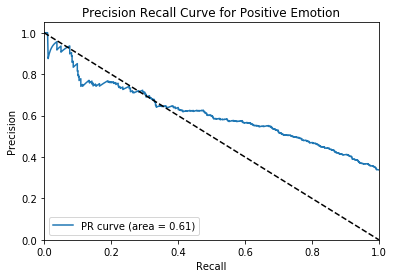

MINIMUM DOCUMENT FREQUENCY = 6

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.97      0.07      0.13       436
No emotion toward brand or product       0.71      0.94      0.81      4124
                  Positive emotion       0.75      0.46      0.57      2295

                          accuracy                           0.72      6855
                         macro avg       0.81      0.49      0.50      6855
                      weighted avg       0.74      0.72      0.69      6855



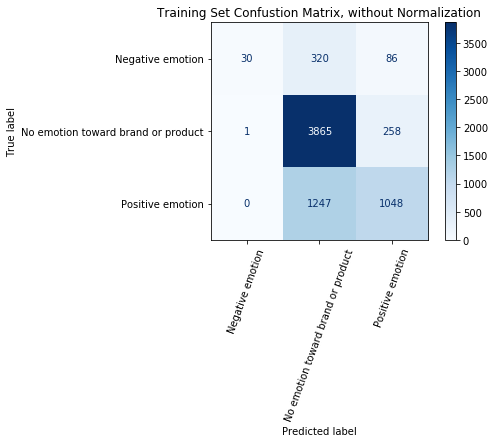

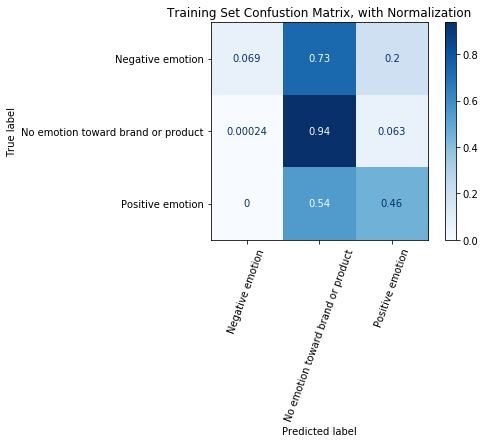

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.50      0.02      0.04       109
No emotion toward brand or product       0.68      0.90      0.78      1031
                  Positive emotion       0.65      0.39      0.49       574

                          accuracy                           0.68      1714
                         macro avg       0.61      0.44      0.43      1714
                      weighted avg       0.66      0.68      0.63      1714



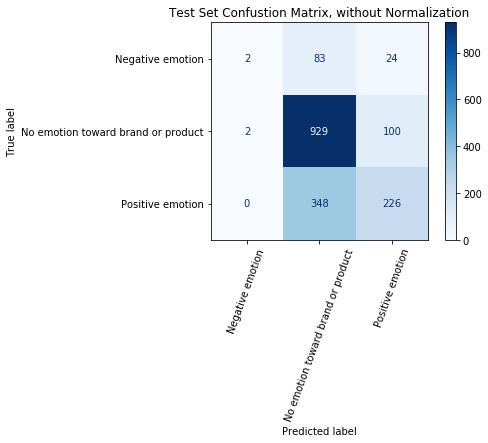

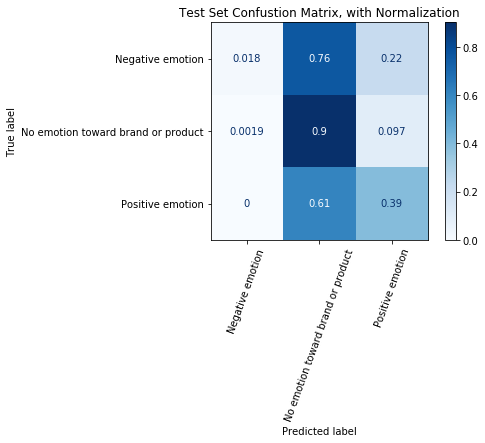

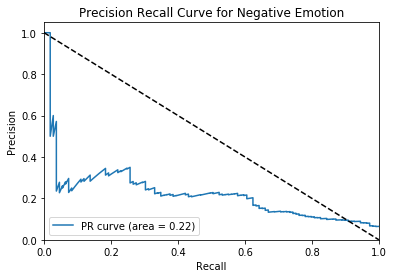

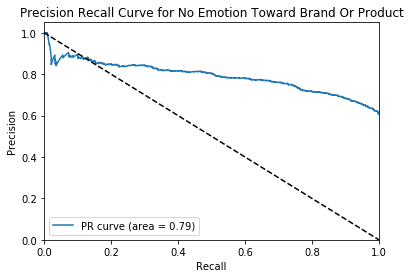

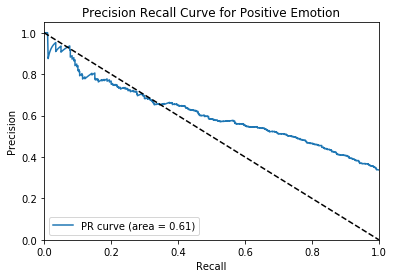

MINIMUM DOCUMENT FREQUENCY = 7

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.94      0.07      0.12       436
No emotion toward brand or product       0.71      0.93      0.81      4124
                  Positive emotion       0.74      0.45      0.56      2295

                          accuracy                           0.72      6855
                         macro avg       0.79      0.48      0.50      6855
                      weighted avg       0.73      0.72      0.68      6855



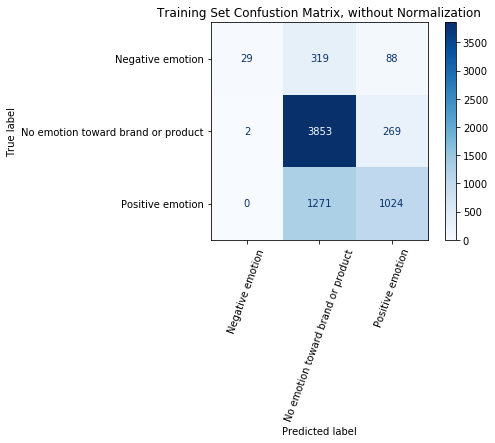

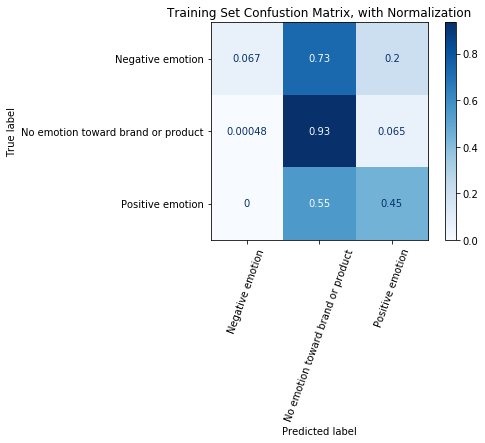

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.50      0.02      0.04       109
No emotion toward brand or product       0.68      0.90      0.78      1031
                  Positive emotion       0.64      0.40      0.49       574

                          accuracy                           0.68      1714
                         macro avg       0.61      0.44      0.43      1714
                      weighted avg       0.66      0.68      0.63      1714



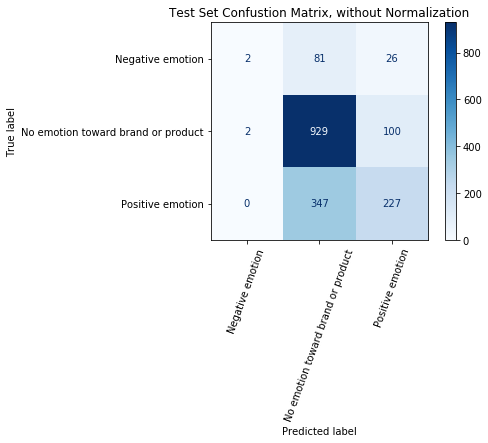

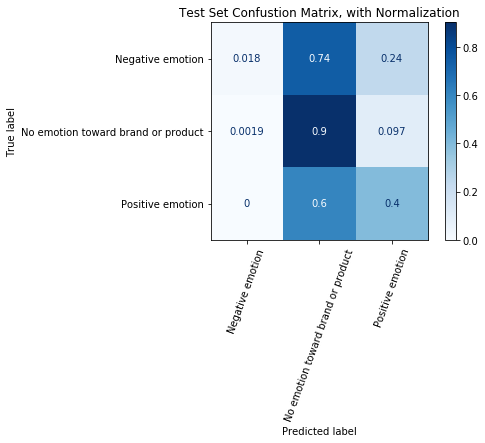

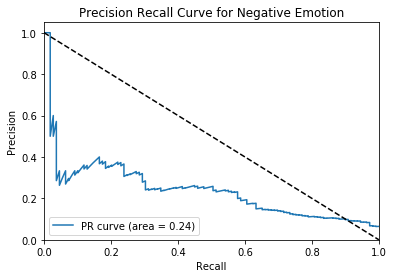

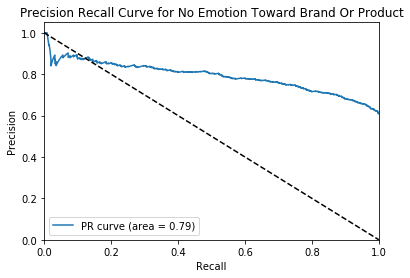

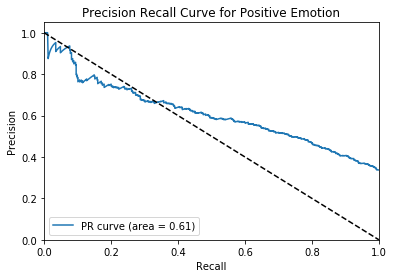

MINIMUM DOCUMENT FREQUENCY = 8

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.94      0.07      0.14       436
No emotion toward brand or product       0.70      0.93      0.80      4124
                  Positive emotion       0.74      0.44      0.55      2295

                          accuracy                           0.71      6855
                         macro avg       0.80      0.48      0.50      6855
                      weighted avg       0.73      0.71      0.68      6855



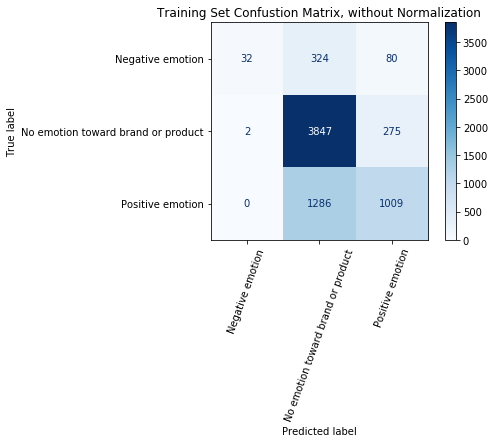

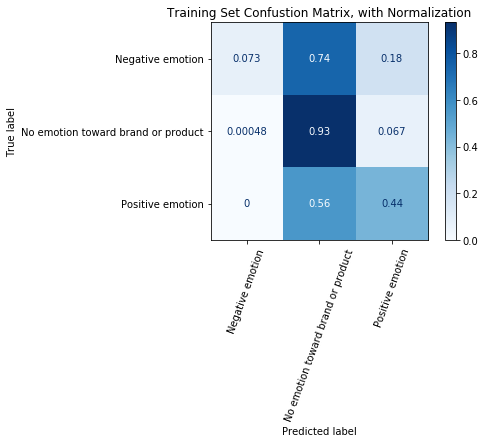

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.50      0.02      0.04       109
No emotion toward brand or product       0.69      0.91      0.78      1031
                  Positive emotion       0.66      0.39      0.49       574

                          accuracy                           0.68      1714
                         macro avg       0.61      0.44      0.44      1714
                      weighted avg       0.66      0.68      0.64      1714



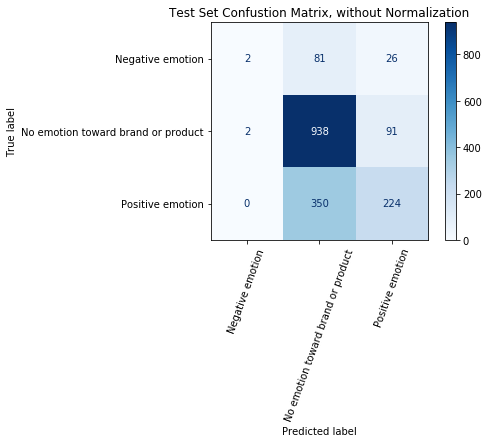

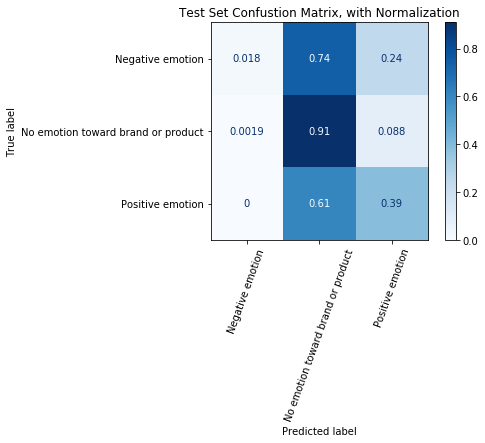

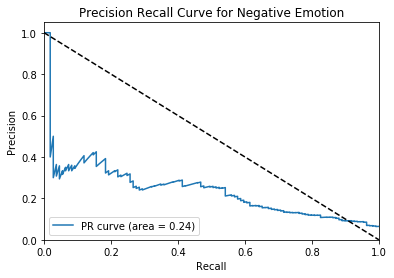

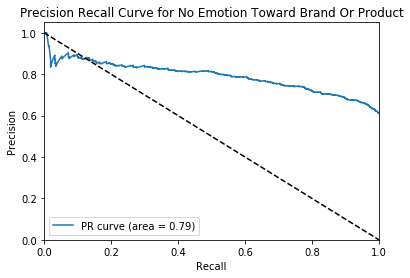

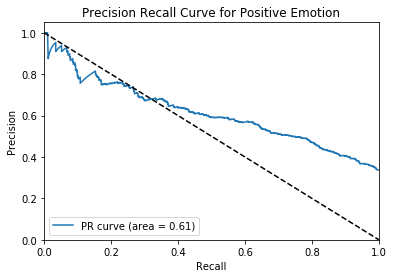

MINIMUM DOCUMENT FREQUENCY = 9

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.92      0.05      0.10       436
No emotion toward brand or product       0.70      0.93      0.80      4124
                  Positive emotion       0.74      0.43      0.54      2295

                          accuracy                           0.71      6855
                         macro avg       0.79      0.47      0.48      6855
                      weighted avg       0.73      0.71      0.67      6855



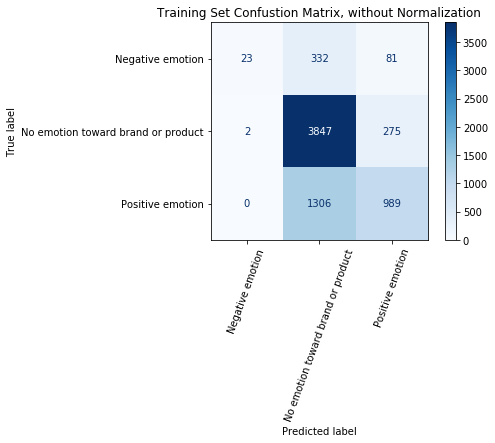

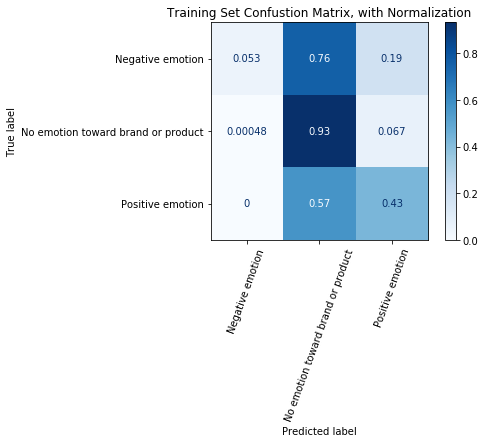

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.50      0.02      0.04       109
No emotion toward brand or product       0.68      0.91      0.78      1031
                  Positive emotion       0.65      0.38      0.48       574

                          accuracy                           0.68      1714
                         macro avg       0.61      0.44      0.43      1714
                      weighted avg       0.66      0.68      0.63      1714



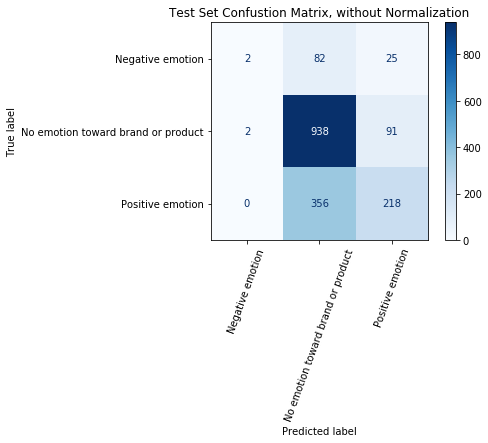

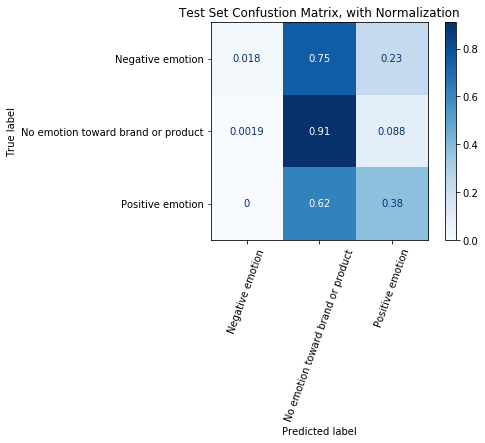

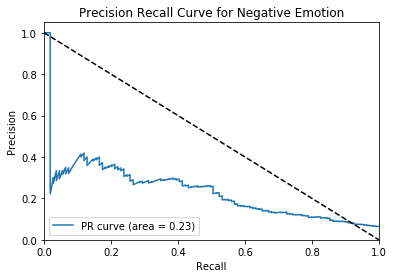

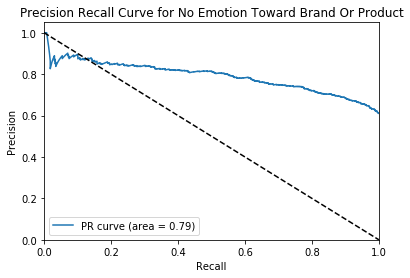

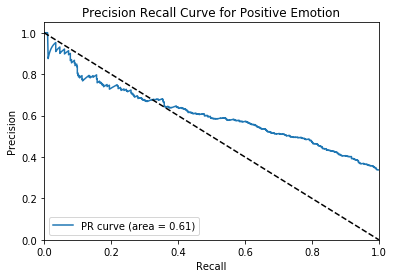

MINIMUM DOCUMENT FREQUENCY = 10

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.93      0.06      0.11       436
No emotion toward brand or product       0.70      0.93      0.80      4124
                  Positive emotion       0.73      0.42      0.53      2295

                          accuracy                           0.71      6855
                         macro avg       0.78      0.47      0.48      6855
                      weighted avg       0.72      0.71      0.67      6855



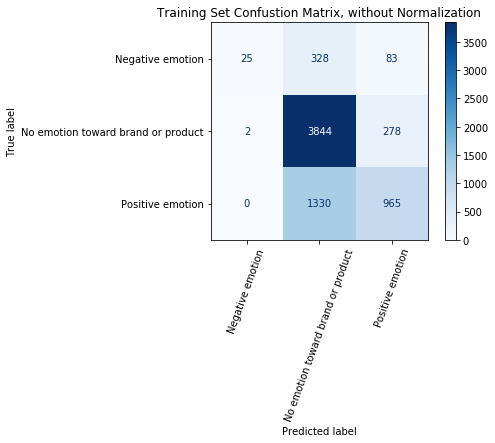

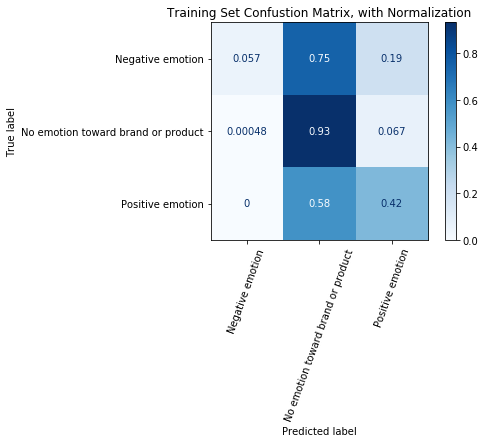

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.50      0.02      0.04       109
No emotion toward brand or product       0.68      0.91      0.78      1031
                  Positive emotion       0.66      0.38      0.48       574

                          accuracy                           0.68      1714
                         macro avg       0.61      0.44      0.43      1714
                      weighted avg       0.66      0.68      0.63      1714



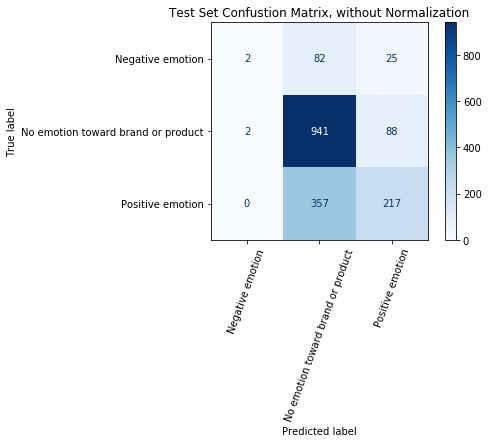

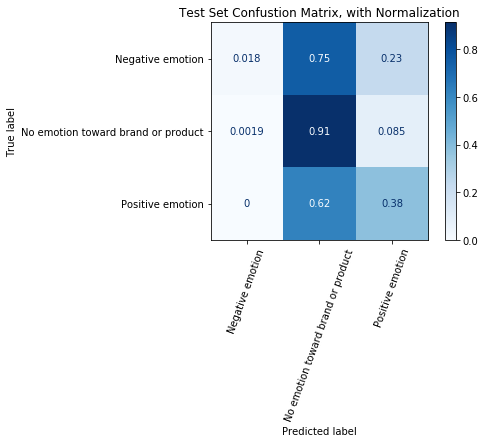

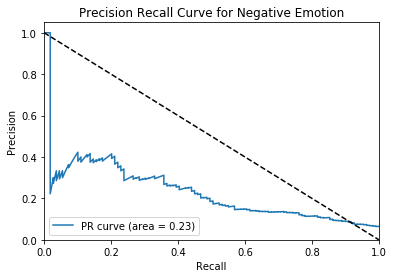

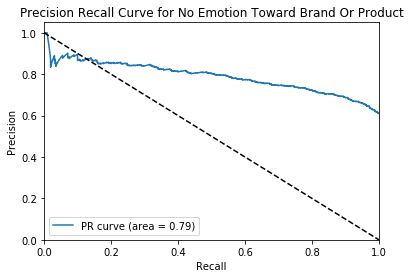

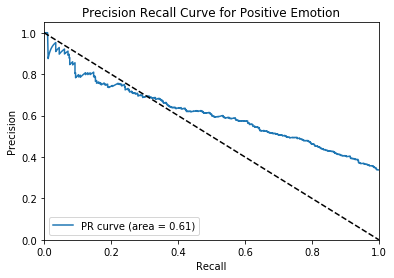

MINIMUM DOCUMENT FREQUENCY = 11

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.93      0.06      0.12       436
No emotion toward brand or product       0.70      0.93      0.80      4124
                  Positive emotion       0.72      0.41      0.52      2295

                          accuracy                           0.70      6855
                         macro avg       0.78      0.47      0.48      6855
                      weighted avg       0.72      0.70      0.66      6855



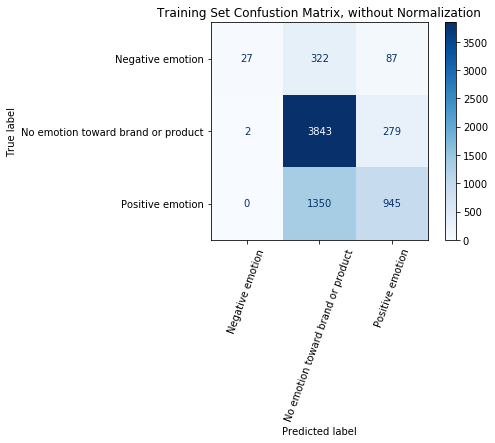

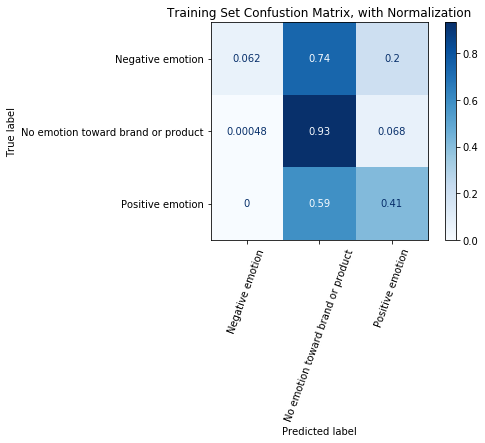

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.40      0.02      0.04       109
No emotion toward brand or product       0.68      0.91      0.78      1031
                  Positive emotion       0.64      0.36      0.46       574

                          accuracy                           0.67      1714
                         macro avg       0.57      0.43      0.43      1714
                      weighted avg       0.65      0.67      0.62      1714



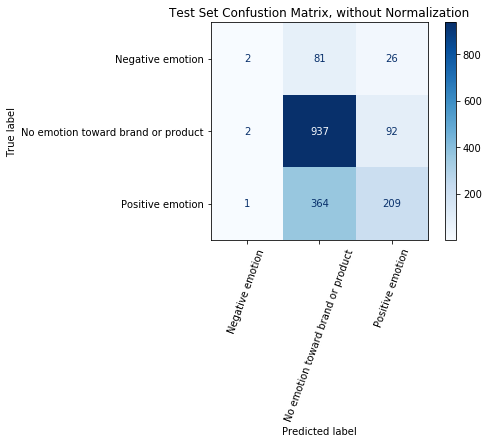

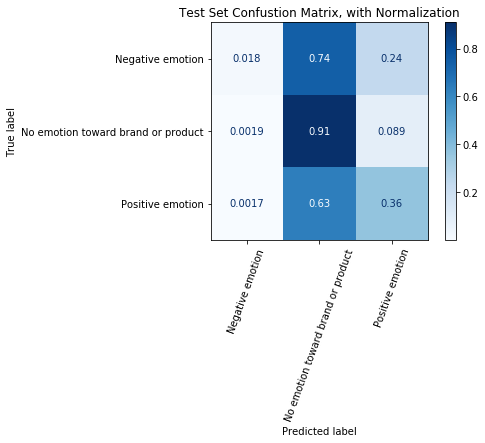

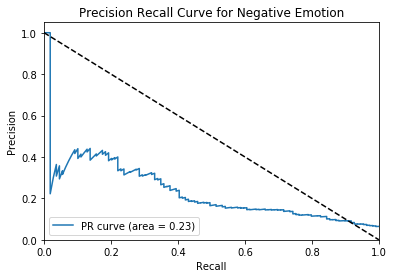

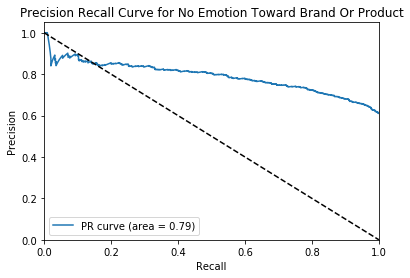

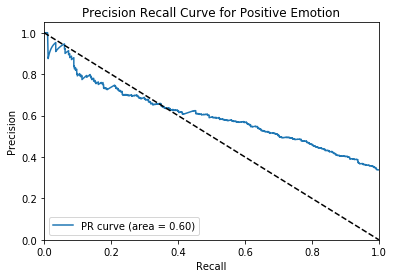

MINIMUM DOCUMENT FREQUENCY = 12

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.93      0.06      0.12       436
No emotion toward brand or product       0.70      0.93      0.80      4124
                  Positive emotion       0.72      0.41      0.52      2295

                          accuracy                           0.70      6855
                         macro avg       0.78      0.47      0.48      6855
                      weighted avg       0.72      0.70      0.66      6855



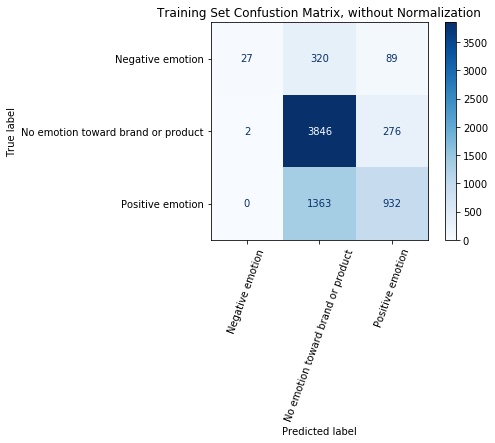

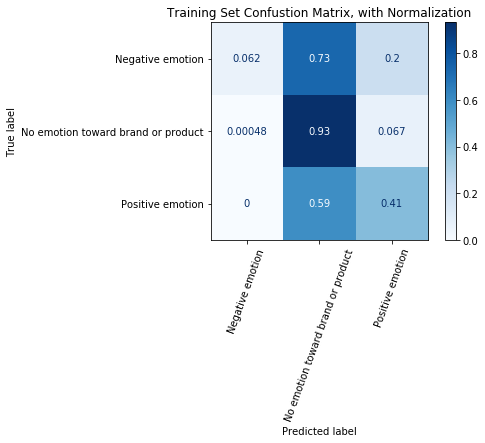

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.33      0.02      0.03       109
No emotion toward brand or product       0.68      0.91      0.78      1031
                  Positive emotion       0.64      0.36      0.46       574

                          accuracy                           0.67      1714
                         macro avg       0.55      0.43      0.42      1714
                      weighted avg       0.64      0.67      0.62      1714



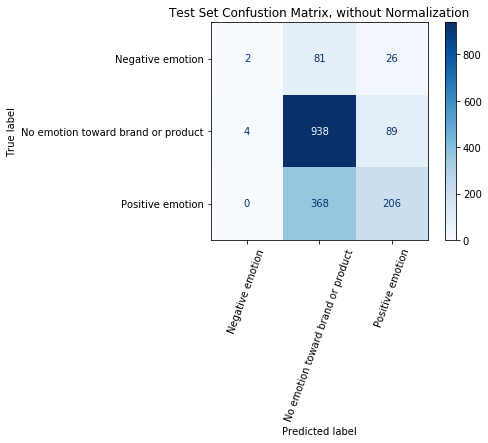

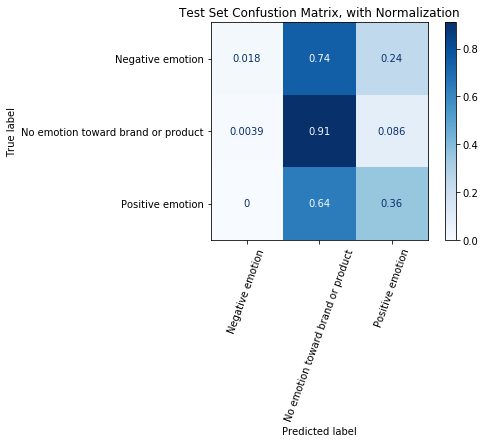

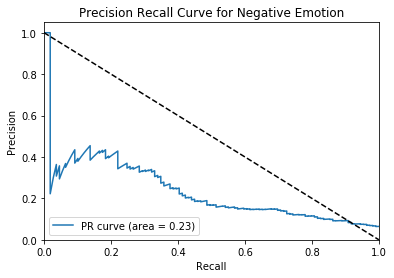

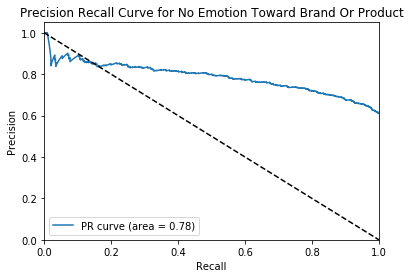

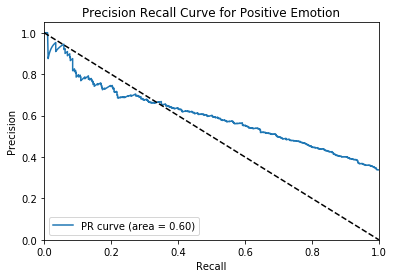

MINIMUM DOCUMENT FREQUENCY = 13

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.90      0.06      0.11       436
No emotion toward brand or product       0.69      0.93      0.80      4124
                  Positive emotion       0.71      0.40      0.51      2295

                          accuracy                           0.70      6855
                         macro avg       0.77      0.46      0.47      6855
                      weighted avg       0.71      0.70      0.66      6855



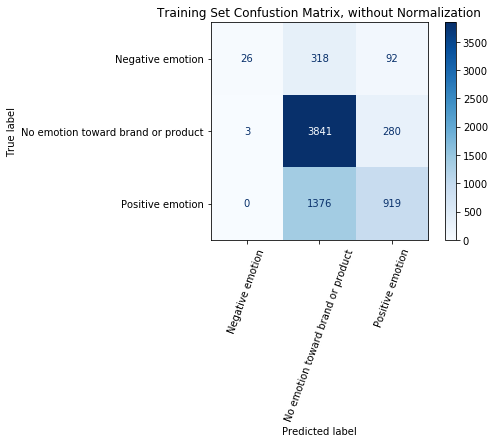

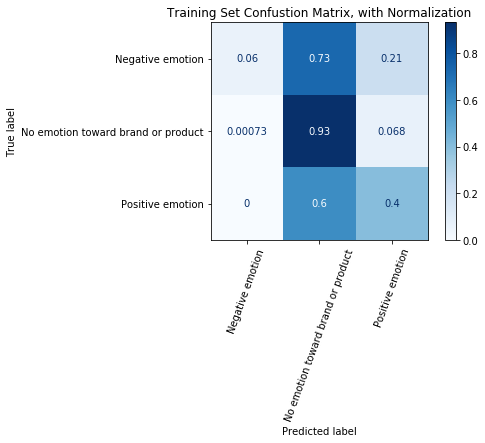

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.01      0.02       109
No emotion toward brand or product       0.68      0.91      0.78      1031
                  Positive emotion       0.64      0.36      0.46       574

                          accuracy                           0.67      1714
                         macro avg       0.52      0.43      0.42      1714
                      weighted avg       0.64      0.67      0.62      1714



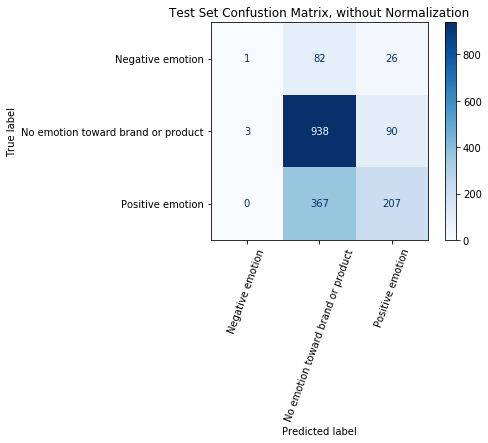

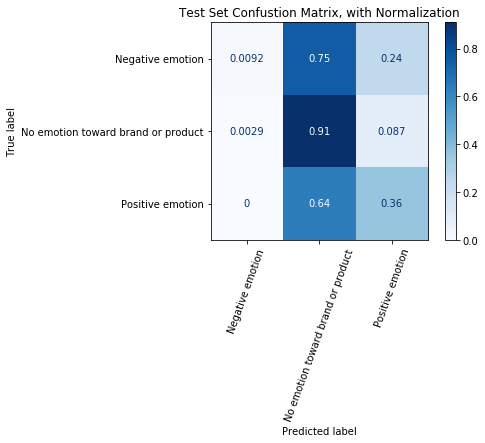

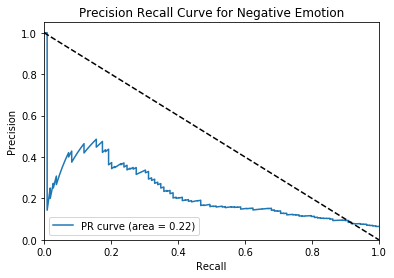

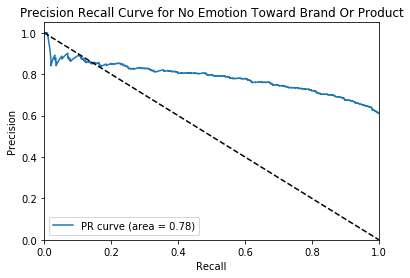

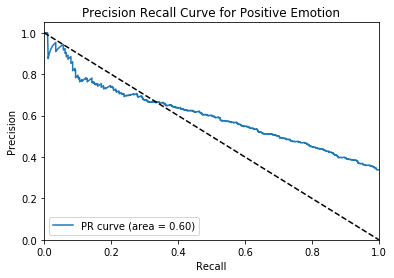

MINIMUM DOCUMENT FREQUENCY = 14

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.87      0.06      0.12       436
No emotion toward brand or product       0.69      0.93      0.79      4124
                  Positive emotion       0.71      0.39      0.51      2295

                          accuracy                           0.70      6855
                         macro avg       0.76      0.46      0.47      6855
                      weighted avg       0.71      0.70      0.65      6855



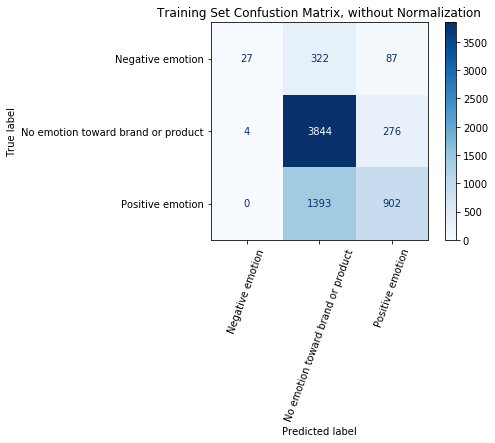

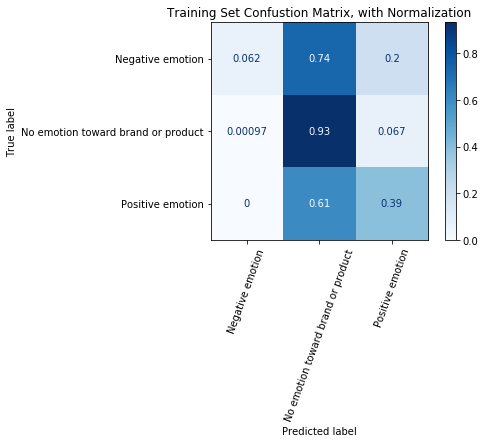

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.20      0.01      0.02       109
No emotion toward brand or product       0.68      0.91      0.78      1031
                  Positive emotion       0.65      0.36      0.46       574

                          accuracy                           0.67      1714
                         macro avg       0.51      0.43      0.42      1714
                      weighted avg       0.64      0.67      0.62      1714



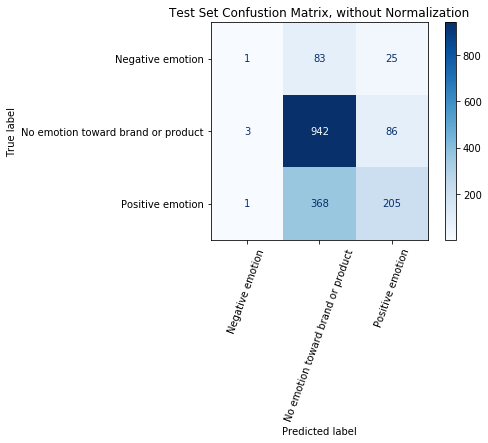

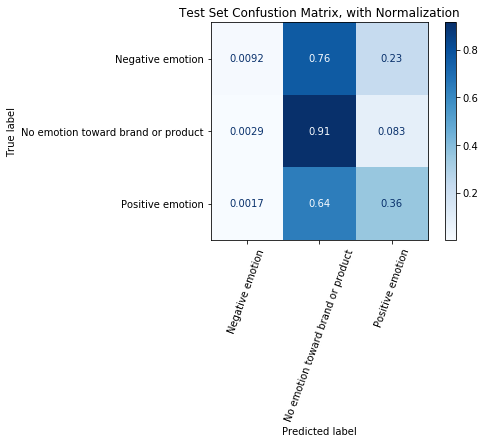

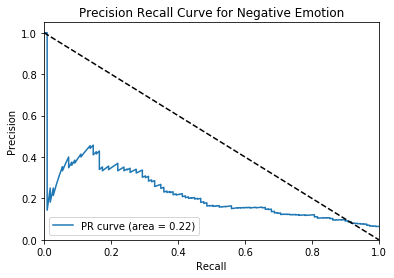

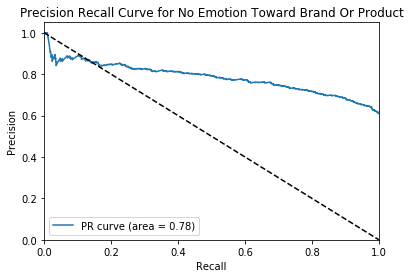

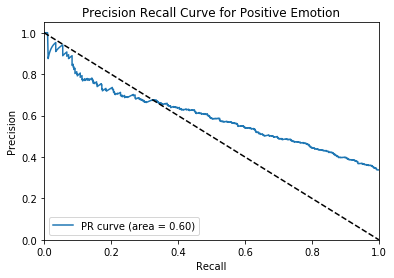

MINIMUM DOCUMENT FREQUENCY = 15

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.87      0.06      0.12       436
No emotion toward brand or product       0.69      0.93      0.79      4124
                  Positive emotion       0.72      0.39      0.50      2295

                          accuracy                           0.70      6855
                         macro avg       0.76      0.46      0.47      6855
                      weighted avg       0.71      0.70      0.65      6855



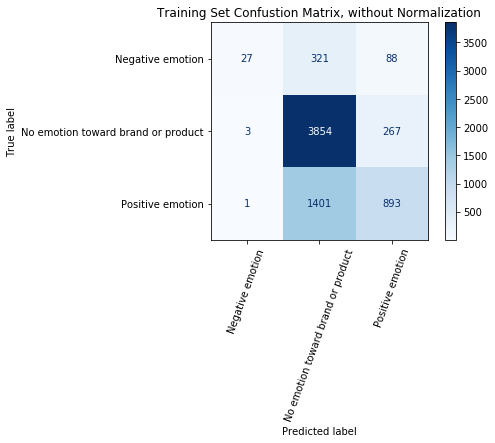

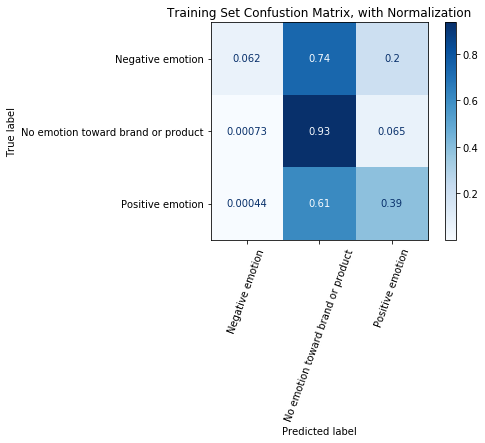

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.20      0.01      0.02       109
No emotion toward brand or product       0.68      0.92      0.78      1031
                  Positive emotion       0.65      0.35      0.46       574

                          accuracy                           0.67      1714
                         macro avg       0.51      0.43      0.42      1714
                      weighted avg       0.64      0.67      0.62      1714



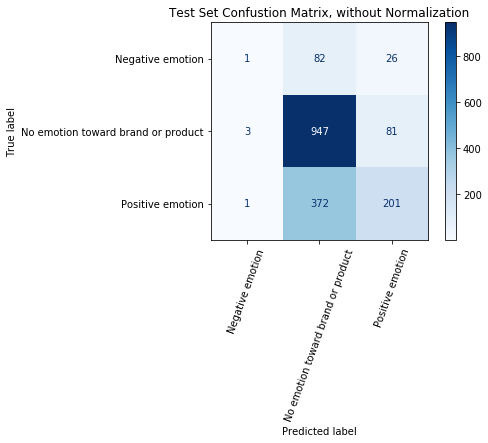

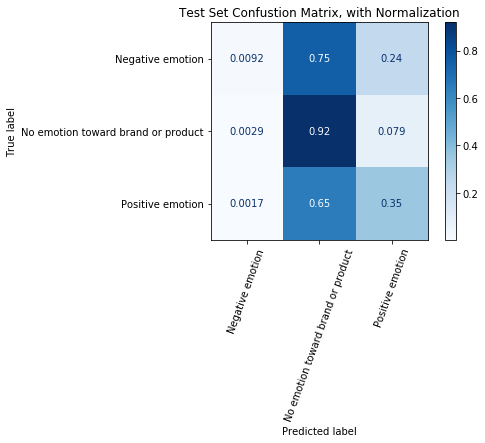

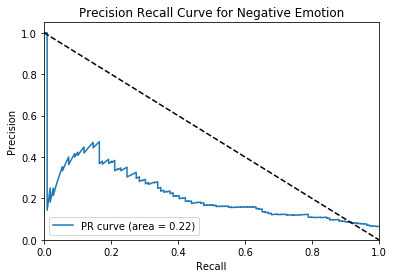

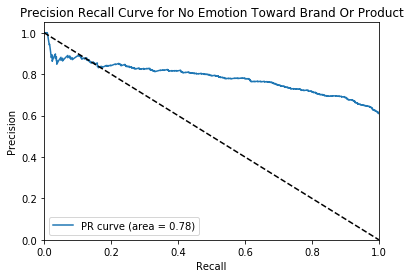

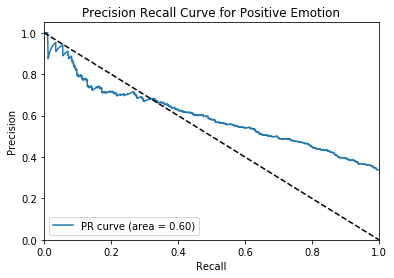

MINIMUM DOCUMENT FREQUENCY = 16

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.85      0.05      0.10       436
No emotion toward brand or product       0.69      0.94      0.79      4124
                  Positive emotion       0.71      0.38      0.49      2295

                          accuracy                           0.69      6855
                         macro avg       0.75      0.46      0.46      6855
                      weighted avg       0.71      0.69      0.65      6855



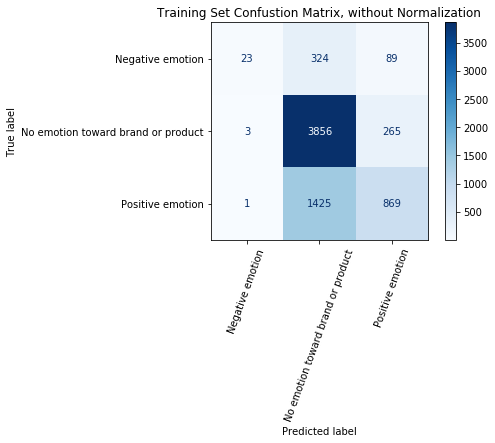

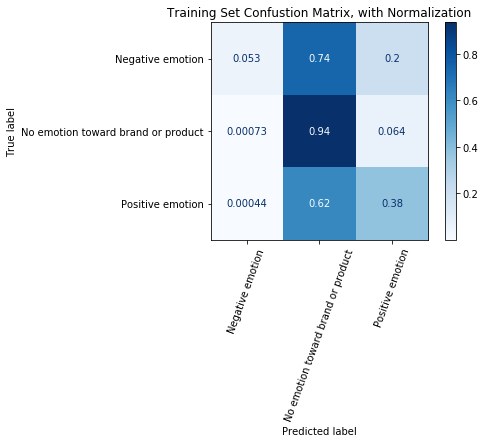

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.20      0.01      0.02       109
No emotion toward brand or product       0.67      0.92      0.78      1031
                  Positive emotion       0.65      0.34      0.44       574

                          accuracy                           0.67      1714
                         macro avg       0.51      0.42      0.41      1714
                      weighted avg       0.64      0.67      0.62      1714



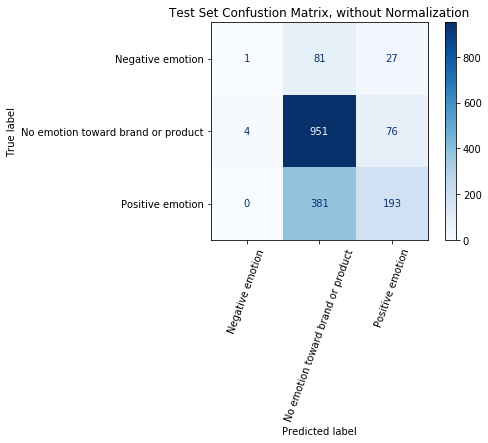

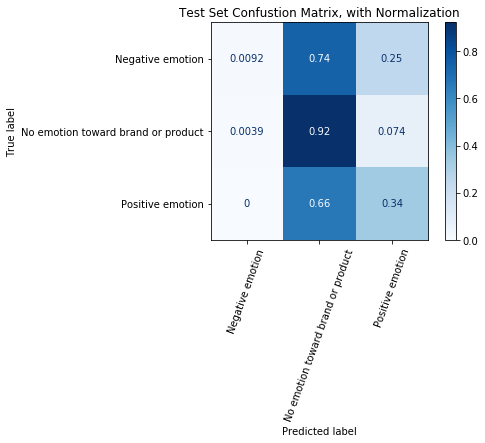

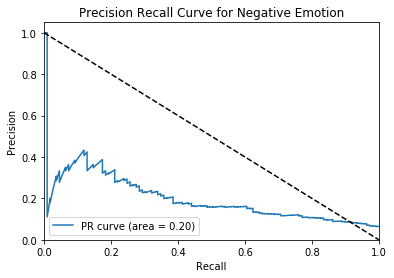

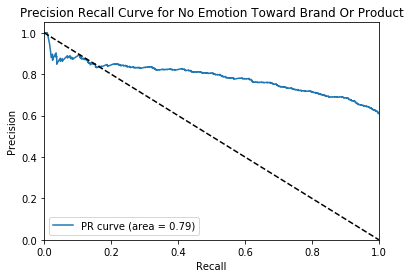

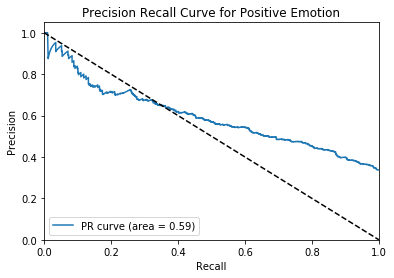

MINIMUM DOCUMENT FREQUENCY = 17

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.86      0.06      0.10       436
No emotion toward brand or product       0.69      0.94      0.79      4124
                  Positive emotion       0.71      0.38      0.49      2295

                          accuracy                           0.69      6855
                         macro avg       0.75      0.46      0.46      6855
                      weighted avg       0.71      0.69      0.65      6855



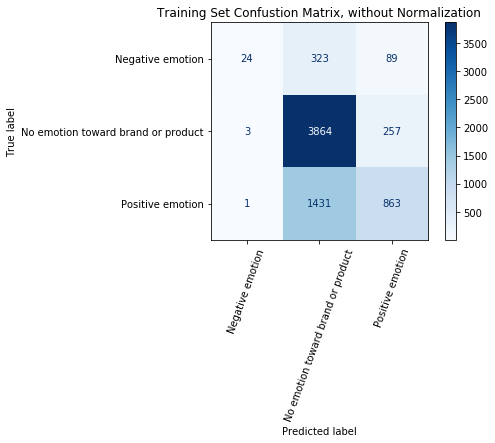

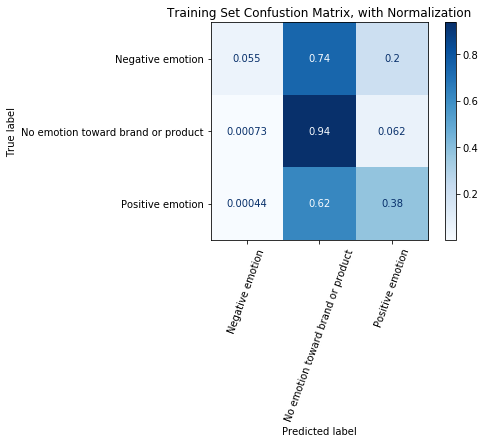

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.01      0.02       109
No emotion toward brand or product       0.68      0.93      0.78      1031
                  Positive emotion       0.67      0.34      0.45       574

                          accuracy                           0.67      1714
                         macro avg       0.53      0.43      0.42      1714
                      weighted avg       0.65      0.67      0.62      1714



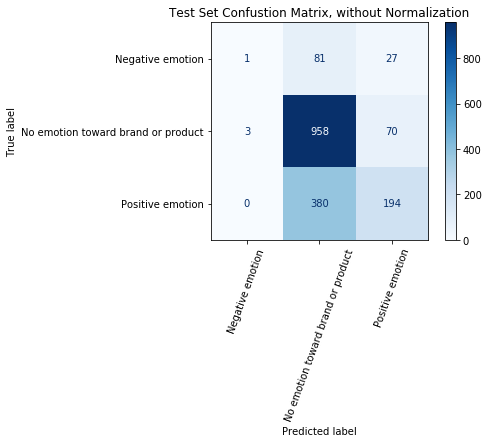

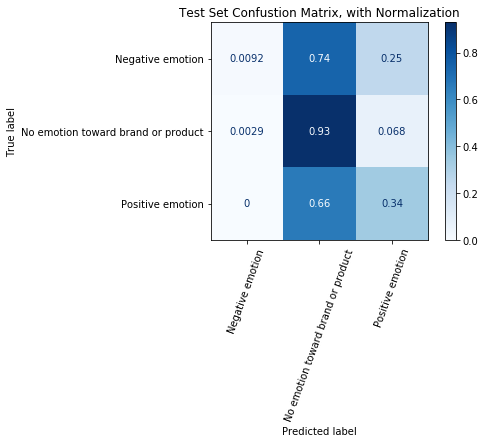

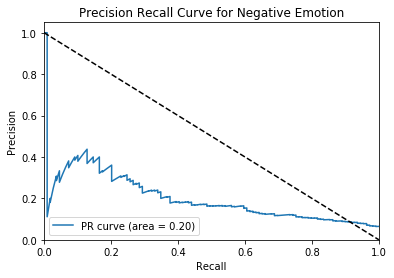

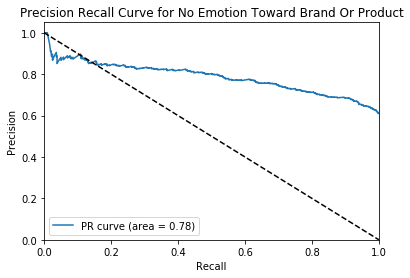

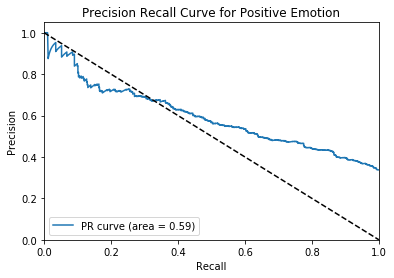

MINIMUM DOCUMENT FREQUENCY = 18

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.86      0.06      0.11       436
No emotion toward brand or product       0.69      0.94      0.79      4124
                  Positive emotion       0.71      0.37      0.49      2295

                          accuracy                           0.69      6855
                         macro avg       0.75      0.46      0.46      6855
                      weighted avg       0.71      0.69      0.65      6855



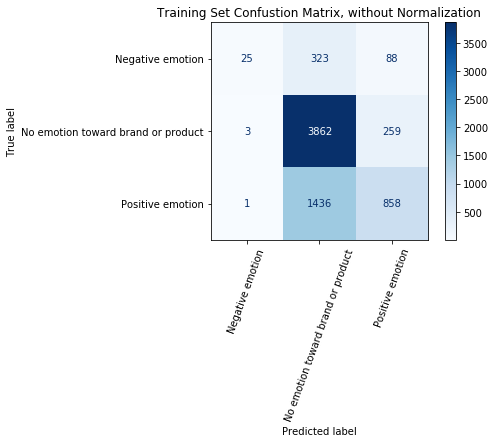

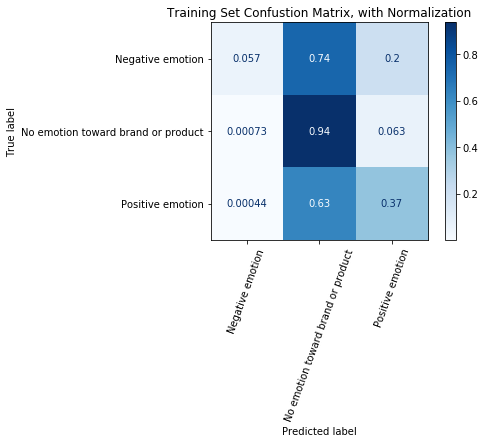

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.20      0.01      0.02       109
No emotion toward brand or product       0.67      0.93      0.78      1031
                  Positive emotion       0.67      0.33      0.45       574

                          accuracy                           0.67      1714
                         macro avg       0.51      0.42      0.41      1714
                      weighted avg       0.64      0.67      0.62      1714



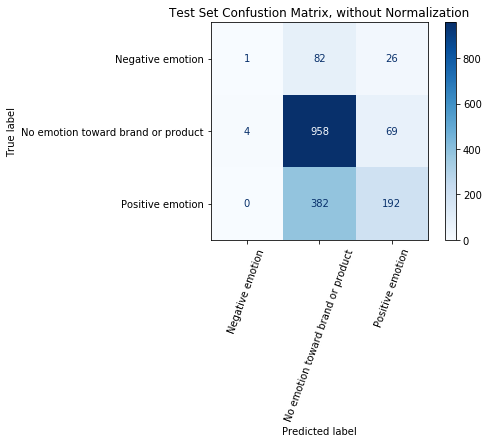

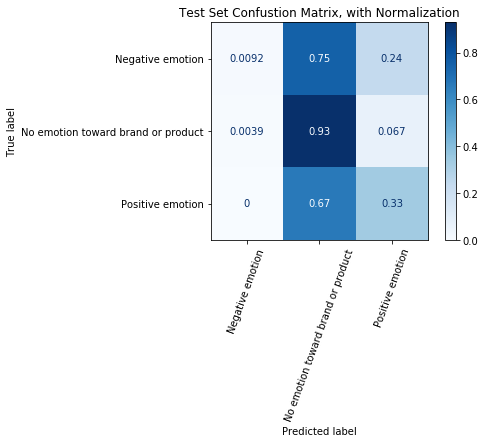

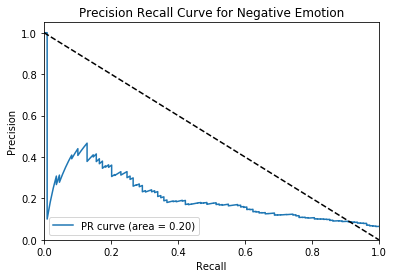

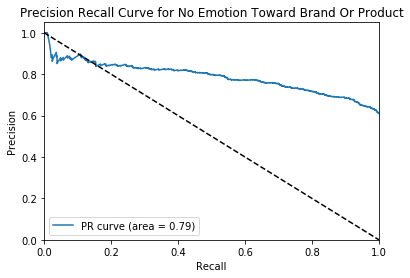

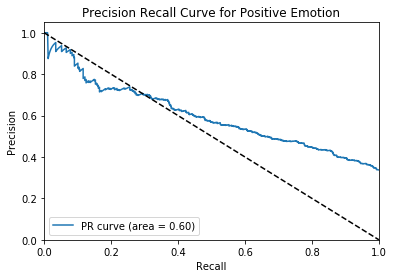

MINIMUM DOCUMENT FREQUENCY = 19

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.86      0.06      0.11       436
No emotion toward brand or product       0.69      0.94      0.79      4124
                  Positive emotion       0.71      0.37      0.48      2295

                          accuracy                           0.69      6855
                         macro avg       0.75      0.45      0.46      6855
                      weighted avg       0.70      0.69      0.65      6855



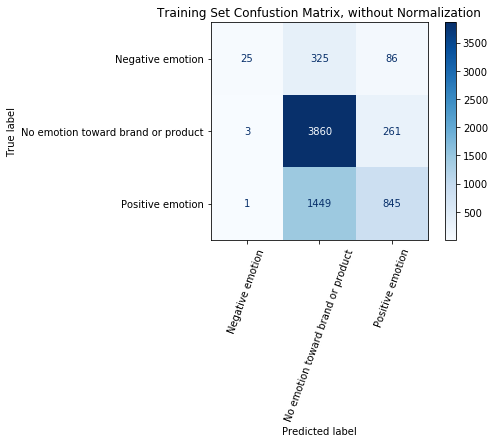

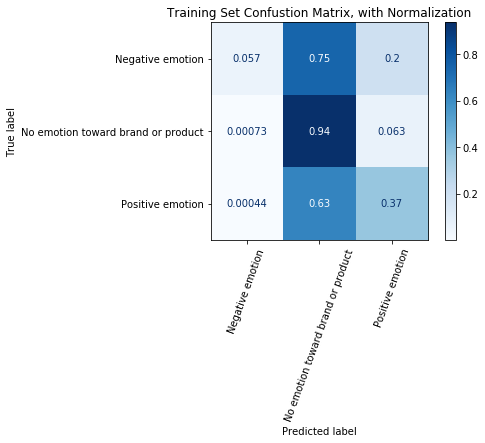

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.01      0.02       109
No emotion toward brand or product       0.67      0.93      0.78      1031
                  Positive emotion       0.68      0.33      0.44       574

                          accuracy                           0.67      1714
                         macro avg       0.53      0.42      0.41      1714
                      weighted avg       0.65      0.67      0.62      1714



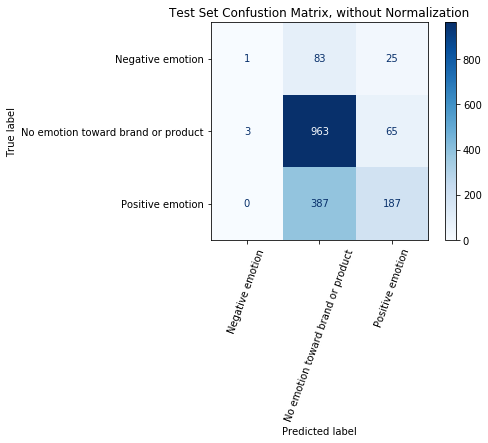

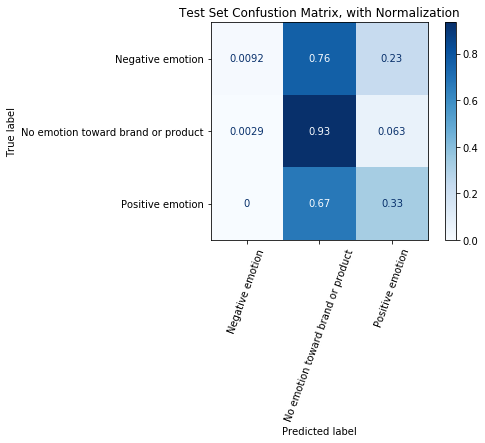

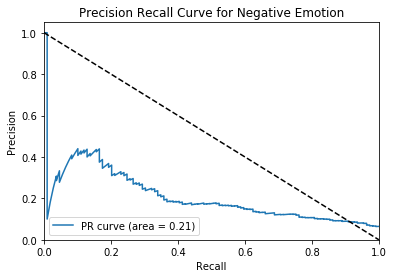

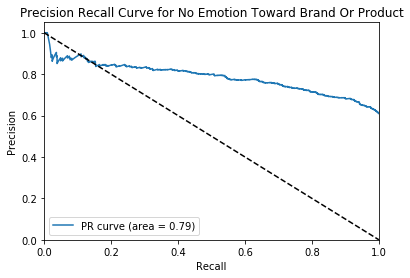

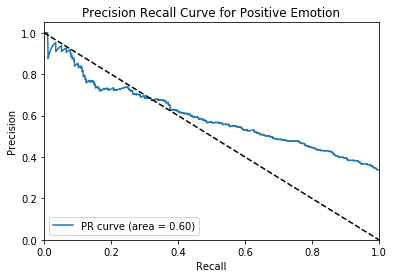

MINIMUM DOCUMENT FREQUENCY = 20

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.87      0.06      0.11       436
No emotion toward brand or product       0.68      0.94      0.79      4124
                  Positive emotion       0.71      0.36      0.48      2295

                          accuracy                           0.69      6855
                         macro avg       0.75      0.45      0.46      6855
                      weighted avg       0.70      0.69      0.64      6855



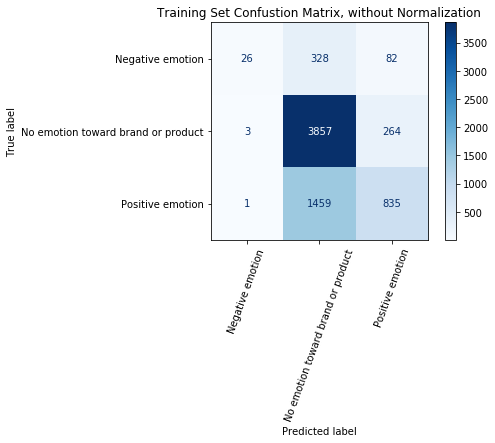

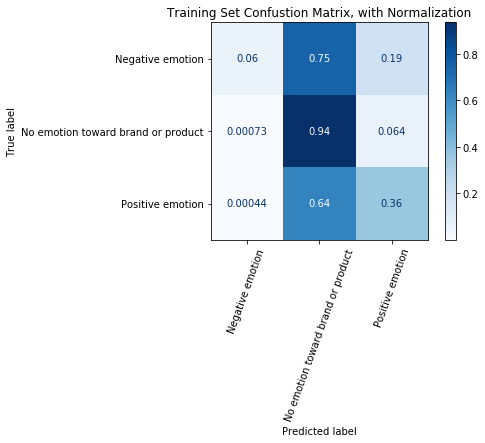

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.25      0.01      0.02       109
No emotion toward brand or product       0.67      0.93      0.78      1031
                  Positive emotion       0.68      0.32      0.44       574

                          accuracy                           0.67      1714
                         macro avg       0.53      0.42      0.41      1714
                      weighted avg       0.65      0.67      0.62      1714



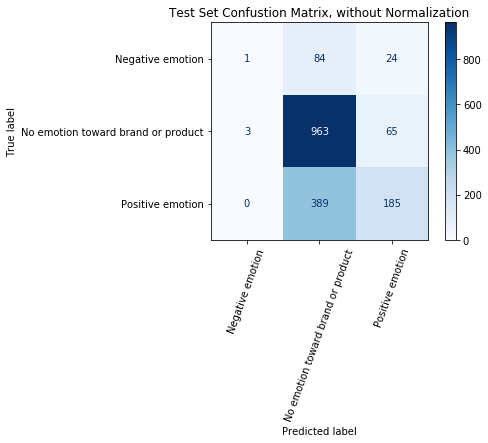

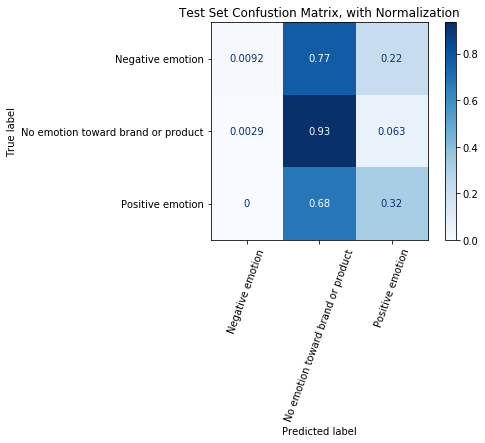

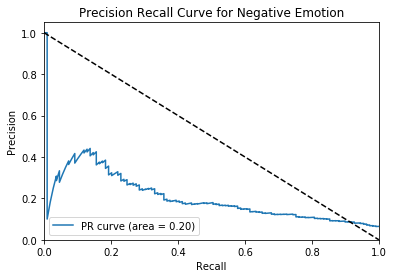

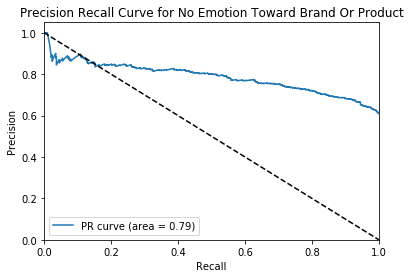

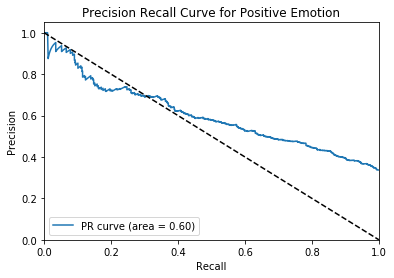

In [16]:
metrics_summary = []

for min_df in range(1,21):
    test_scores = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)

In [17]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'train accuracy',
                                           'test accuracy',
                                          'neg recall',
                                          'neutral recall',
                                          'pos recall'])

metrics_summary_df

min doc freq  train accuracy  test accuracy  neg recall  neutral recall  \
0            1.0        0.734646       0.654609    0.018349        0.963143   
1            2.0        0.745150       0.670362    0.018349        0.942774   
2            3.0        0.741648       0.671529    0.018349        0.914646   
3            4.0        0.733042       0.670945    0.018349        0.901067   
4            5.0        0.728082       0.667445    0.018349        0.895247   
5            6.0        0.721080       0.675029    0.018349        0.901067   
6            7.0        0.715682       0.675613    0.018349        0.901067   
7            8.0        0.713056       0.679113    0.018349        0.909796   
8            9.0        0.708826       0.675613    0.018349        0.909796   
9           10.0        0.705179       0.676779    0.018349        0.912706   
10          11.0        0.702407       0.669778    0.018349        0.908826   
11          12.0        0.700948       0.668611    0.018349        0.909796   
12          13.0        0.698177       0.668611    0.009174        0.909796   
13          14.0        0.696280       0.669778    0.009174        0.913676   
14          15.0        0.696426       0.670362    0.009174        0.918526   
15          16.0        0.692633       0.668028    0.009174        0.922405   
16          17.0        0.693071       0.672695    0.009174        0.929195   
17          18.0        0.692195       0.671529    0.009174        0.929195   
18          19.0        0.690007       0.671529    0.009174        0.934045   
19          20.0        0.688257       0.670362    0.009174        0.934045   

    pos recall  
0     0.221254  
1     0.304878  
2     0.358885  
3     0.381533  
4     0.381533  
5     0.393728  
6     0.395470  
7     0.390244  
8     0.379791  
9     0.378049  
10    0.364111  
11    0.358885  
12    0.360627  
13    0.357143  
14    0.350174  
15    0.336237  
16    0.337979  
17    0.334495  
18    0.325784  
19    0.322300

MINIMUM DOCUMENT FREQUENCY = 4

Classification Report for Training Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.97      0.06      0.12       436
No emotion toward brand or product       0.72      0.95      0.82      4124
                  Positive emotion       0.78      0.48      0.59      2295

                          accuracy                           0.73      6855
                         macro avg       0.82      0.50      0.51      6855
                      weighted avg       0.76      0.73      0.70      6855



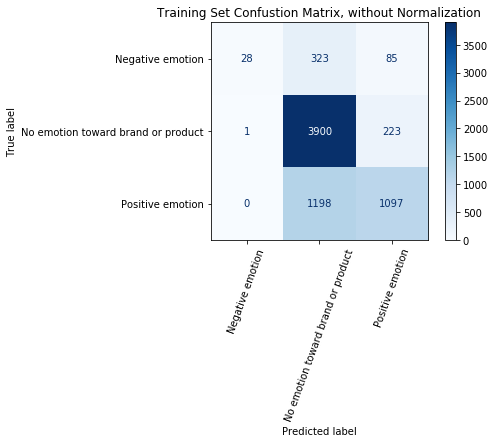

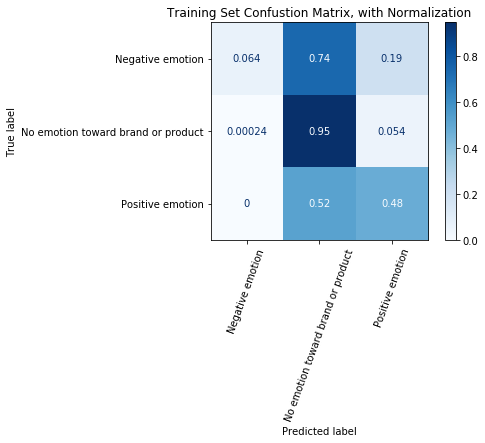

Classification Report for Test Set
                                    precision    recall  f1-score   support

                  Negative emotion       0.50      0.02      0.04       109
No emotion toward brand or product       0.68      0.90      0.77      1031
                  Positive emotion       0.64      0.38      0.48       574

                          accuracy                           0.67      1714
                         macro avg       0.61      0.43      0.43      1714
                      weighted avg       0.65      0.67      0.63      1714



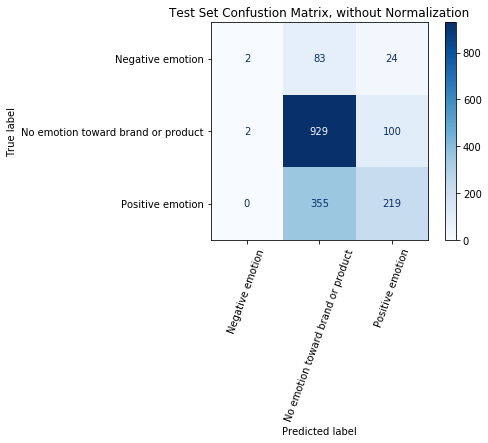

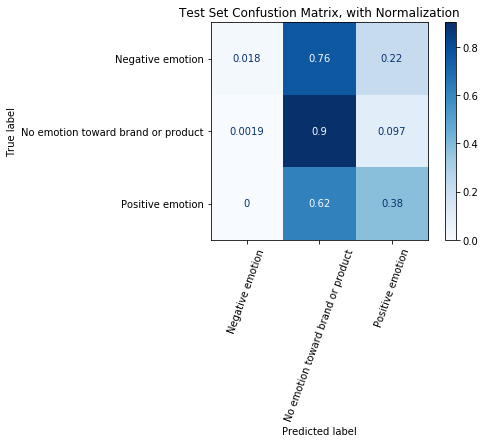

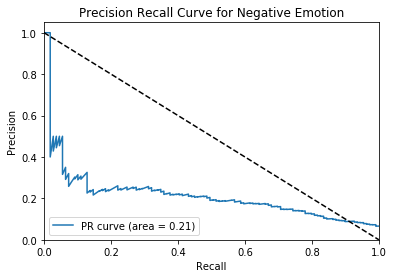

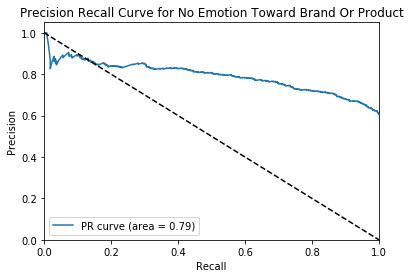

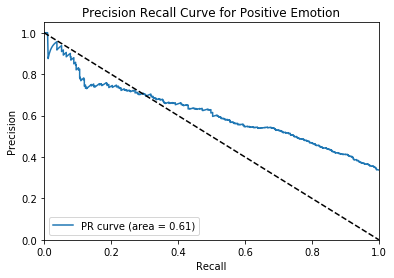

In [18]:
metrics = train_and_eval_model(min_df=4)

# Summary

The model using tf/idf did worse than the baseline overall, although it did correctly identify 90% of the majority class.